# Data Cleaning

I used spacy to lemmatize all the data. 
Data:
- lowercase
- alphanumeric
- no functional words.
- tf-idf is used. I used different parameters for TF-IDF vectorizer.

I noticed some duplication in training data. I removed those duplications.

# Experiments

Vanilla experiment (exp 1) uses two different classifiers (SVM and SGD [linear SVM]). I also tried RandomForest but I filtered out that. I tried to optimize hyperparameters but I didn't go well with my current laptop. It takes for a while to do gridsearch. The best F1-weighted accuracy on Dev set was 0.83 with SGD. Because of the skewness of the data I used class_weight params for each classifier but I couldn't search well the parameter space I think; it didn't give good regularization. According to confusion matrix, either I am regularize too much (classifier labels everything with **misc** or too less; classifier labels most of the stuff with majority of classes (**customer**, or **order**). Better hyperparameter optimization is necessary.

Another experiment (exp2) uses the same classifiers but this time I tried downsampling, too. I used different fractions of the instances labeled as **order**.

Third experiment was using PCA to reduce the dimensions and run the similar experiments. This experiment showed, especially for Random Forest classifier, few number of dimensions (7 for instance) is enough to get .81 weighted F1 score. This is good for scalability.

Unfortunately, I couldn't make much experiments on different ngram sizes which may be very helpful. I would try to use bigger ngrams but my machine does not allow me to search the parameter space.

# Other remedies to try:

1. Train a language model and generate data.
2. Regularize better
    - more experiment with hyperparams.
    - any possibility to give weights to scoring metric? It's possible to give weights to samples, so we can do it. The problem is I'm using grid_search function of sklearn. GridSearch makes the K-Folds inside. It does not allow me to give sample_weight immediately. I think changing sample weights might increase weighted f1, but for this project, I am going to skip this.
3. Ensemble: According confusion matrix of each model; the models seem complementary. I might combine those models by VotingClassifier.  
4. There are other methods to search hyperspace more efficiently. For instance, random search (http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a) or Distributed Asynchronous Hyper-parameter Optimization (hyperopt)

# Output

Lastly, I embed all the data (train + dev) and predict test data for two classifiers with their best settings.

In [1]:
%matplotlib inline
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from data import *
from utils import *
from experiment import *
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

plt.style.use('ggplot')
warnings.filterwarnings(action='always')
warnings.simplefilter('ignore')

order        2234
customer      886
shopper       195
applicant      43
misc            7
Name: label, dtype: int64

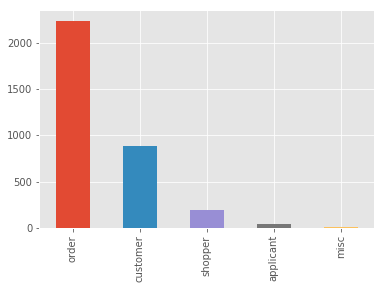

In [2]:
# Train/dev label dist.
dataset = get_data_path()
dev_df = read_data(dataset['dev'])
train_df = read_data(dataset['train'])

draw_label_dist(train_df)
train_df['label'].value_counts()

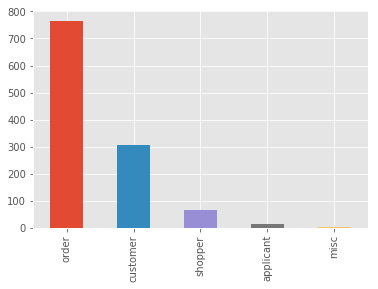

In [3]:
draw_label_dist(dev_df)

In [13]:
# Frequent (most likely not useful) words.
most_common_for_each_labels(train_df)

applicant
[('i', 789), ('you', 646), ('and', 431), ('that', 422), ('the', 417), ('to', 308), ('okay', 303), ('for', 282), ('so', 245), ('on', 203), ('have', 196), ('my', 193), ('a', 184), ('is', 170), ('your', 167), ("i'm", 154), ('yeah', 154), ('thank', 143), ('can', 142), ('it', 141), ('one', 135), ('alright', 131), ('do', 129), ('in', 125), ('like', 111), ('just', 109), ('me', 107), ('what', 107), ('now', 104), ('with', 100), ('go', 99), ('know', 98), ('not', 96), ('no', 92), ('but', 91), ('be', 87), ("that's", 86), ('here', 84), ('right', 80), ('there', 77), ('phone', 75), ("don't", 74), ('order', 73), ('was', 73), ('then', 71), ('or', 69), ('see', 69), ('of', 69), ('account', 67), ('yes', 66)]

customer
[('i', 12863), ('you', 10395), ('the', 6567), ('that', 6543), ('and', 6343), ('okay', 6028), ('for', 5217), ('so', 4514), ('to', 3996), ('my', 3397), ('thank', 3240), ('one', 2919), ("i'm", 2696), ('on', 2657), ('have', 2546), ('alright', 2379), ('is', 2359), ('a', 2334), ('can', 2

In [4]:
# Different sample weights.

inverse_weights = calc_inverse_weight_for_labels(train_df)
uniform_weights = calc_uniform_weight_for_labels(train_df)
weight_df = pd.DataFrame({"labels": ['applicant', 'customer', 'misc', 'order', 'shopper'],
                         "weights": [2., 1.5, 2.1, 1.01, 1.02]})
weight_df['weights_2'] = weight_df['weights'] ** 2
weight_df['weights_3'] = weight_df['weights'] ** 3.1
weights_1 = dict(zip(weight_df['labels'].tolist(), weight_df['weights'].tolist()))
weights_2 = dict(zip(weight_df['labels'].tolist(), weight_df['weights_2'].tolist()))
weights_3 = dict(zip(weight_df['labels'].tolist(), weight_df['weights_3'].tolist()))

In [5]:
# Parameter space.

stop_words = get_stopwords()

tf_idf_params = {
    'tfidf__max_df': (0.8, 1.0),
    'tfidf__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
}

sgd_params = {
    'clf__alpha': (0.0001, 0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__max_iter': (500, 1000),
#     'clf__class_weight': [inverse_weights, uniform_weights]
}

random_forest_params = {
    "clf__n_estimators": (10, 20),
    "clf__criterion": ('gini', 'entropy'),
    "clf__max_depth": (5, 7, 10, 30),
#     'clf__class_weight': [inverse_weights, uniform_weights]
}

svm_params = {
    'clf__C': (1, 10, 100, 1000),
    'clf__class_weight': [uniform_weights, weights_1, weights_2, weights_3]
}

classifiers = [
    (SVC(decision_function_shape='ovo'), svm_params),
    (SGDClassifier(shuffle=True), sgd_params),
#     (RandomForestClassifier(class_weight=uniform_weights), random_forest_params),
]

In [92]:
# Experiment 1.
# best_pipes_exp1 = vanilla_experiment(DATASET, classifiers, tf_idf_params)

3365 1155
Performing grid search...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__C': (1, 10, 100, 1000),
 'clf__class_weight': [{'applicant': 1,
                        'customer': 1,
                        'misc': 1,
                        'order': 1,
                        'shopper': 1},
                       {'applicant': 2.0,
                        'customer': 1.5,
                        'misc': 2.1,
                        'order': 1.01,
                        'shopper': 1.02},
                       {'applicant': 4.0,
                        'customer': 2.25,
                        'misc': 4.41,
                        'order': 1.0201,
                        'shopper': 1.0404},
                       {'applicant': 8.574187700290345,
                        'customer': 3.514656635974386,
                        'misc': 9.97423999265871,
                        'order': 1.0313266937978396,
                        'shopper': 1.0633115527569217}],
 'tfidf__max_df': (0.8, 1.

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 20.0min finished


done in 1207.422s

Best score: 0.802
Best parameters set:
	clf__C: 1000
	clf__class_weight: {'applicant': 2.0, 'customer': 1.5, 'misc': 2.1, 'order': 1.01, 'shopper': 1.02}
	tfidf__max_df: 0.8
	tfidf__ngram_range: (1, 1)
Performing grid search...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__alpha': (0.0001, 1e-05, 1e-06),
 'clf__max_iter': (500, 1000),
 'clf__penalty': ('l2', 'elasticnet'),
 'tfidf__max_df': (0.8, 1.0),
 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 19.0min finished


done in 1161.862s

Best score: 0.801
Best parameters set:
	clf__alpha: 0.0001
	clf__max_iter: 500
	clf__penalty: 'elasticnet'
	tfidf__max_df: 0.8
	tfidf__ngram_range: (1, 2)
Score on Dev data SVC: 0.8162038175392933
Score on Dev data SGDClassifier: 0.8288550382913862
array([[2169,    0,    0,    0,   65],
       [ 165,    2,    0,    0,   28],
       [  13,    0,   26,    0,    4],
       [   0,    0,    0,    5,    2],
       [ 110,    0,    1,    0,  775]])

array([[728,   0,   0,   0,  37],
       [ 50,   0,   0,   0,  17],
       [ 11,   0,   0,   0,   4],
       [  1,   0,   0,   1,   1],
       [ 54,   0,   0,   0, 251]])

['order', 'shopper', 'applicant', 'misc', 'customer']
array([[2169,    0,    0,    0,   65],
       [ 165,    2,    0,    0,   28],
       [  13,    0,   26,    0,    4],
       [   0,    0,    0,    5,    2],
       [ 110,    0,    1,    0,  775]])
array([[728,   0,   0,   0,  37],
       [ 50,   0,   0,   0,  17],
       [ 11,   0,   0,   0,   4],
       [  1

2471 1155
Performing grid search...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__C': (1, 10, 100, 1000),
 'clf__class_weight': [{'applicant': 1,
                        'customer': 1,
                        'misc': 1,
                        'order': 1,
                        'shopper': 1},
                       {'applicant': 2.0,
                        'customer': 1.5,
                        'misc': 2.1,
                        'order': 1.01,
                        'shopper': 1.02},
                       {'applicant': 4.0,
                        'customer': 2.25,
                        'misc': 4.41,
                        'order': 1.0201,
                        'shopper': 1.0404},
                       {'applicant': 8.574187700290345,
                        'customer': 3.514656635974386,
                        'misc': 9.97423999265871,
                        'order': 1.0313266937978396,
                        'shopper': 1.0633115527569217}],
 'tfidf__max_df': (0.8, 1.

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 12.6min finished


done in 758.683s

Best score: 0.748
Best parameters set:
	clf__C: 100
	clf__class_weight: {'applicant': 2.0, 'customer': 1.5, 'misc': 2.1, 'order': 1.01, 'shopper': 1.02}
	tfidf__max_df: 0.8
	tfidf__ngram_range: (1, 1)
Performing grid search...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__alpha': (0.0001, 1e-05, 1e-06),
 'clf__max_iter': (500, 1000),
 'clf__penalty': ('l2', 'elasticnet'),
 'tfidf__max_df': (0.8, 1.0),
 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  9.8min finished


done in 593.594s

Best score: 0.750
Best parameters set:
	clf__alpha: 1e-06
	clf__max_iter: 500
	clf__penalty: 'l2'
	tfidf__max_df: 0.8
	tfidf__ngram_range: (1, 2)
Score on Dev data SVC: 0.8039857413854203
Score on Dev data SGDClassifier: 0.8299050620750452
array([[   0,  171,   24,    0,    0],
       [   0, 1266,   74,    0,    0],
       [   0,  160,  726,    0,    0],
       [   0,    3,    4,    0,    0],
       [   0,   32,   11,    0,    0]])

array([[  0,  53,  14,   0,   0],
       [  0, 716,  49,   0,   0],
       [  0,  55, 250,   0,   0],
       [  0,   1,   2,   0,   0],
       [  0,  12,   3,   0,   0]])

['shopper', 'order', 'customer', 'misc', 'applicant']
array([[ 195,    0,    0,    0,    0],
       [   0, 1340,    0,    0,    0],
       [   0,    0,  886,    0,    0],
       [   0,    0,    0,    7,    0],
       [   0,    0,    0,    0,   43]])

array([[  5,  51,  11,   0,   0],
       [  2, 718,  45,   0,   0],
       [  0,  36, 269,   0,   0],
       [  0,   1,   

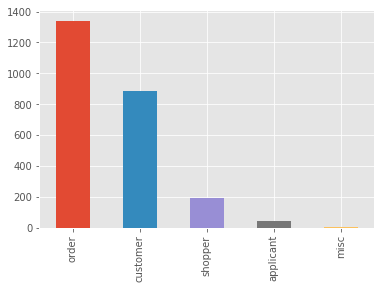

In [6]:
# Experiment 2.
best_pipes_exp2 = run_downsample_experiment(DATASET, classifiers, tf_idf_params, frac=0.6, stop_words=get_stopwords())

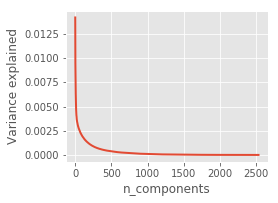

In [60]:
train_df = read_data(dataset['train'])
dev_df = read_data(dataset['dev'])
X_train, y_train, X_dev, y_dev = get_train_dev_data(train_df, dev_df)
pca = dim_reduction_with_pca(X_train, vectorizer=None)
draw_explained_variance(pca)

In [ ]:
best_pipes = best_pipes_exp2
for pipe in best_pipes:
    calc_score_on_dev_after_dim_reduction(pipe.get_params()['clf'], X_train, y_train, X_dev, y_dev, stop_words=stop_words)

In [36]:
from constants import NLP
from copy import deepcopy

def prepare_data(df, no_label=False, nlp=NLP):
    X = lemmatize_data(df['text'].tolist(), nlp)
    if no_label:
        return X
    
    y = df['label'].tolist()
    return X, y

def get_test_data(df, nlp=NLP):
    return prepare_data(df, nlp=NLP, no_label=True)

test_df = read_data(dataset['test'])
X_test = get_test_data(test_df)

best_pipeline = best_pipes_exp2[1]
train_df = read_data(dataset['train'])
dev_df = read_data(dataset['dev'])

train_df = downsample_train_data(train_df, frac=0.7) # downsample 'order' class for train.  
dev_df = downsample_train_data(dev_df, frac=0.5) # downsample 'order' class for dev.

X_train, y_train, X_dev, y_dev = get_train_dev_data(train_df, dev_df)

print(len(X_train), len(X_dev))
        
pred_test_with_best_model(best_pipeline, X_train, y_train, X_dev, y_dev, X_test)

2695 772
3467 3467


array(['customer', 'order', 'customer', ..., 'order', 'customer', 'order'],
      dtype='<U9')